In [1]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

In [2]:
# loading in the data for training
from google.colab import drive

drive.mount('/content/gdrive')

!cp "gdrive/MyDrive/NLP_RNN/rus.txt" ./
!cp "gdrive/MyDrive/NLP_RNN/glove.6B.50d.txt" ./

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 40  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 15000  # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 50

We would need target sentence shifted by one for teacher forcing, so that during training we always pass the correct previous prediction (correcting model from wrong guessing).

In [4]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

# load in the data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open('./rus.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation, *rest = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 15000


In [5]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

Found 2272 unique input tokens.
Found 8016 unique output tokens.


For the Encoder part we will use pre-padding, because it'll help model to remember all the relevant features carried in hidden states. Bu for the Decoder there is no need to do this.

In [6]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (15000, 5)
encoder_inputs[0]: [ 0  0  0  0 11]
decoder_inputs[0]: [   2 3642    0    0    0    0    0    0    0    0    0]
decoder_inputs.shape: (15000, 11)


Embedding layer maps sequences of integers (tokenized texts) into sequences of word vectors (embeddings). These vectors should be constructed in a such way, that similar words (can be fit into the same context) would be close to each other (Euclidean distance). These are all weights that are found from unsupervised pre-training via different algorithms. In our case - GloVe50. 

In [7]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join(f'./glove.6B.{EMBEDDING_DIM}d.txt')) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [8]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

Filling pre-trained embeddings...


Each token in each target sentence should be represented as OHE vector for training. We put 1 based on the token's value.

In [9]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1

## Building the model

For the Encoder we'll not need to return sequences at each token, as we'll pass exactly the final hidden and cell state to the Decoder at the initial stage.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 50)        113650      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 11, 50)       400850      input_2[0][0]                    
______________________________________________________________________________________________

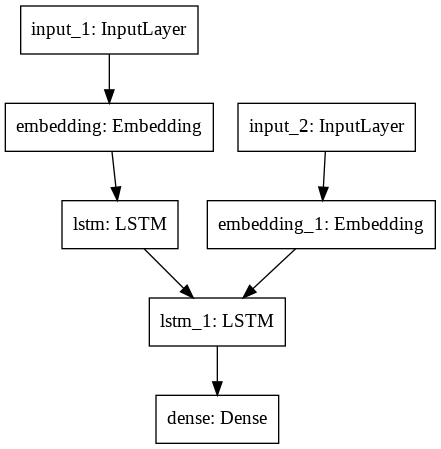

In [10]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True
)
encoder_outputs, h, c = encoder(x)

# keep only the states to pass into decoder
encoder_states = [h, c]

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# as it depends on the target language
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True, # won't need here, but will need for prediction
  return_state=True
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

print(model.summary())
plot_model(model)

In [11]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

In [12]:
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Epoch 1/40
188/188 [==============================] - 10s 35ms/step - loss: 5.5205 - acc: 0.3543 - val_loss: 5.5315 - val_acc: 0.2770
Epoch 2/40
188/188 [==============================] - 5s 26ms/step - loss: 4.5141 - acc: 0.3801 - val_loss: 5.2842 - val_acc: 0.2953
Epoch 3/40
188/188 [==============================] - 5s 26ms/step - loss: 4.0924 - acc: 0.4184 - val_loss: 5.0675 - val_acc: 0.3634
Epoch 4/40
188/188 [==============================] - 5s 26ms/step - loss: 3.7282 - acc: 0.4545 - val_loss: 4.8963 - val_acc: 0.3903
Epoch 5/40
188/188 [==============================] - 5s 26ms/step - loss: 3.4232 - acc: 0.4799 - val_loss: 4.8157 - val_acc: 0.4164
Epoch 6/40
188/188 [==============================] - 5s 26ms/step - loss: 3.1567 - acc: 0.4981 - val_loss: 4.7714 - val_acc: 0.4272
Epoch 7/40
188/188 [==============================] - 5s 26ms/step - loss: 2.9199 - acc: 0.5146 - val_loss: 4.7605 - val_acc: 0.4395
Epoch 8/40
188/188 [==============================] - 5s 26ms/step -

## Sampling model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             400850      input_5[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

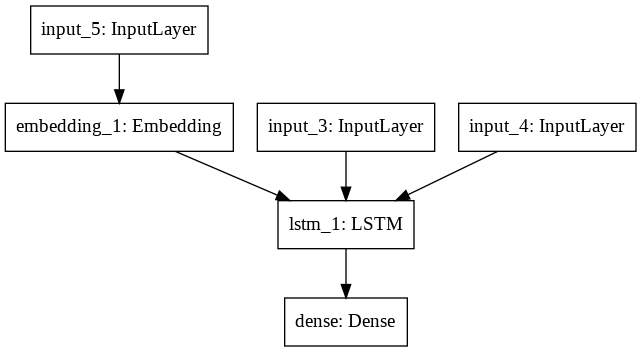

In [13]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

print(decoder_model.summary())
plot_model(decoder_model)

In [14]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}


def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)

In [ ]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: Is Tom big?
Translation: фома большой?
Continue? [Y/n]y
-
Input: We're so busy.
Translation: мы так думаем.
Continue? [Y/n]y
-
Input: You're thin.
Translation: вы худой.
Continue? [Y/n]y
-
Input: I made coffee.
Translation: я сделал кофе.
Continue? [Y/n]y
-
Input: Don't be pigs.
Translation: не будьте свиньями.
Continue? [Y/n]y
-
Input: That's true.
Translation: это точно.
